# Show4DSTEM Adaptive Sparse Benchmark (20/30/40%)
Dose-quality benchmark with repeated runs, confidence intervals, and publication figure exports.

In [1]:
try:
    %load_ext autoreload
    %autoreload 2
    %env ANYWIDGET_HMR=1
except Exception:
    pass

env: ANYWIDGET_HMR=1


In [ ]:
import json
import math
import pathlib
import numpy as np
import torch
import quantem.widget
from quantem.widget import Show4DSTEM
def make_crystal_4dstem(
    scan_shape=(40, 40),
    det_shape=(72, 72),
    n_frames=1,
    seed=7,
    device=None,
):
    if device is None:
        device = torch.device(
            "mps"
            if torch.backends.mps.is_available()
            else "cuda"
            if torch.cuda.is_available()
            else "cpu"
        )
    torch.manual_seed(seed)
    sy, sx = scan_shape
    ky, kx = det_shape
    fy = 1.0 if n_frames == 1 else float(n_frames)
    y = torch.linspace(-1.0, 1.0, sy, device=device)
    x = torch.linspace(-1.0, 1.0, sx, device=device)
    Y, X = torch.meshgrid(y, x, indexing="ij")
    frame_axis = torch.linspace(0.0, 1.0, n_frames, device=device)
    phase_t = 2.0 * math.pi * frame_axis[:, None, None]
    # Synthetic strain/defect field with crystal-like periodicity.
    lattice = 0.35 * torch.sin(2.0 * math.pi * (7.0 * X + 0.35 * Y))
    lattice += 0.30 * torch.sin(2.0 * math.pi * (7.0 * Y - 0.25 * X))
    defect = 0.55 * torch.exp(-((X + 0.20) ** 2 + (Y - 0.25) ** 2) / 0.05)
    defect += 0.35 * torch.exp(-((X - 0.35) ** 2 + (Y + 0.10) ** 2) / 0.03)
    structural = lattice + defect
    structural_t = structural[None, :, :] + 0.08 * torch.sin(phase_t + 5.0 * X[None, :, :])
    ky_axis = torch.linspace(0.0, float(ky - 1), ky, device=device)
    kx_axis = torch.linspace(0.0, float(kx - 1), kx, device=device)
    KY, KX = torch.meshgrid(ky_axis, kx_axis, indexing="ij")
    KY = KY[None, None, None, :, :]
    KX = KX[None, None, None, :, :]
    cy = (ky - 1) / 2.0
    cx = (kx - 1) / 2.0
    # Shift Bragg spots according to local strain/field.
    shift_y = 1.4 * structural_t[:, :, :, None, None]
    shift_x = -1.1 * structural_t[:, :, :, None, None]
    frame_mod = 1.0 + 0.20 * torch.sin(phase_t)[:, :, :, None, None]
    dp = torch.zeros((n_frames, sy, sx, ky, kx), device=device)
    sigma_direct = 2.8
    direct_amp = 180.0 * frame_mod
    dp += direct_amp * torch.exp(-((KY - cy) ** 2 + (KX - cx) ** 2) / (2.0 * sigma_direct**2))
    spot_sigma = 2.1
    base_spots = [
        (-16.0, 0.0, 75.0),
        (16.0, 0.0, 75.0),
        (0.0, -16.0, 72.0),
        (0.0, 16.0, 72.0),
        (-11.0, -11.0, 58.0),
        (11.0, 11.0, 58.0),
        (-11.0, 11.0, 54.0),
        (11.0, -11.0, 54.0),
    ]
    amp_field = 1.0 + 0.45 * torch.relu(structural_t)[:, :, :, None, None]
    for dy, dx, amp in base_spots:
        cy_t = cy + dy + shift_y
        cx_t = cx + dx + shift_x
        dp += (amp * amp_field) * torch.exp(
            -((KY - cy_t) ** 2 + (KX - cx_t) ** 2) / (2.0 * spot_sigma**2)
        )
    ring_r = torch.sqrt((KY - cy) ** 2 + (KX - cx) ** 2)
    dp += 12.0 * torch.exp(-((ring_r - 23.0) ** 2) / (2.0 * 7.0**2))
    if device.type == "mps":
        # MPS currently lacks aten::poisson; sample on CPU then move back.
        shot = torch.poisson(torch.clamp(dp.cpu(), min=0.0)).to(device)
    else:
        shot = torch.poisson(torch.clamp(dp, min=0.0))
    dp = shot + 0.6 * torch.randn_like(shot)
    dp = torch.clamp(dp, min=0.0).to(torch.float32)
    arr = dp.cpu().numpy()
    if n_frames == 1:
        return arr[0]
    return arr
DEVICE = torch.device(
    "mps"
    if torch.backends.mps.is_available()
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using device: {DEVICE}")
import matplotlib.pyplot as plt
def compute_vi_circle(data4d: np.ndarray, center: tuple[float, float], radius: float) -> np.ndarray:
    arr = np.asarray(data4d, dtype=np.float32)
    rows, cols, ky, kx = arr.shape
    rr, cc = np.meshgrid(np.arange(ky, dtype=np.float32), np.arange(kx, dtype=np.float32), indexing='ij')
    mask = ((rr - float(center[0])) ** 2 + (cc - float(center[1])) ** 2) <= float(radius) ** 2
    return (arr * mask[None, None, :, :]).sum(axis=(2, 3)).astype(np.float32)
def idw_reconstruct(shape: tuple[int, int], points: list[tuple[int, int]], values: np.ndarray, power: float = 2.0, k: int = 12) -> np.ndarray:
    pts = np.asarray(points, dtype=np.float32)
    vals = np.asarray(values, dtype=np.float32)
    if pts.size == 0:
        return np.zeros(shape, dtype=np.float32)
    rr, cc = np.meshgrid(np.arange(shape[0], dtype=np.float32), np.arange(shape[1], dtype=np.float32), indexing='ij')
    coords = np.stack([rr.reshape(-1), cc.reshape(-1)], axis=1)
    d2 = ((coords[:, None, :] - pts[None, :, :]) ** 2).sum(axis=2) + 1e-6
    if k > 0 and pts.shape[0] > k:
        idx = np.argpartition(d2, kth=k - 1, axis=1)[:, :k]
        d2 = np.take_along_axis(d2, idx, axis=1)
        vals_local = vals[idx]
    else:
        vals_local = np.broadcast_to(vals[None, :], d2.shape)
    weights = 1.0 / np.power(d2, power / 2.0)
    pred = (weights * vals_local).sum(axis=1) / np.maximum(weights.sum(axis=1), 1e-6)
    return pred.reshape(shape).astype(np.float32)
def nrmse(pred: np.ndarray, target: np.ndarray) -> float:
    diff = np.asarray(pred, dtype=np.float32) - np.asarray(target, dtype=np.float32)
    rmse = float(np.sqrt(np.mean(diff * diff)))
    denom = float(np.max(target) - np.min(target) + 1e-6)
    return rmse / denom
def psnr(pred: np.ndarray, target: np.ndarray) -> float:
    mse = float(np.mean((np.asarray(pred, dtype=np.float32) - np.asarray(target, dtype=np.float32)) ** 2))
    peak = float(np.max(target))
    if mse <= 0:
        return 120.0
    return 20.0 * np.log10(max(peak, 1e-6)) - 10.0 * np.log10(mse)
def regular_grid_points(shape: tuple[int, int], target_count: int) -> list[tuple[int, int]]:
    rows, cols = shape
    step = max(1, int(round(np.sqrt((rows * cols) / max(1, target_count)))))
    pts = [(r, c) for r in range(0, rows, step) for c in range(0, cols, step)]
    if len(pts) >= target_count:
        return pts[:target_count]
    all_pts = [(r, c) for r in range(rows) for c in range(cols)]
    seen = set(pts)
    for pt in all_pts:
        if pt not in seen:
            pts.append(pt)
        if len(pts) >= target_count:
            break
    return pts
def random_points(shape: tuple[int, int], target_count: int, seed: int) -> list[tuple[int, int]]:
    rng = np.random.default_rng(seed)
    rows, cols = shape
    flat = rng.choice(rows * cols, size=target_count, replace=False)
    return [(int(idx // cols), int(idx % cols)) for idx in flat]
def summarize_ci(values: list[float]) -> tuple[float, float, float]:
    arr = np.asarray(values, dtype=np.float64)
    mean = float(arr.mean())
    sem = float(arr.std(ddof=1) / np.sqrt(max(1, arr.size))) if arr.size > 1 else 0.0
    ci = 1.96 * sem
    return mean, mean - ci, mean + ci
print(f"quantem.widget {quantem.widget.__version__}")

In [3]:
OUT = pathlib.Path('notebooks/show4dstem/paper_benchmark')
OUT.mkdir(parents=True, exist_ok=True)
data = make_crystal_4dstem(scan_shape=(44, 44), det_shape=(72, 72), n_frames=1, seed=21, device=DEVICE)
w = Show4DSTEM(data, pixel_size=0.82, k_pixel_size=0.50)
w.auto_detect_center()
w.roi_circle()
w.roi_radius = 13
w.dp_scale_mode = 'log'
w.show_fft = True
gt_vi = compute_vi_circle(data, center=(w.center_row, w.center_col), radius=w.roi_radius)
scan_shape = gt_vi.shape
n_total = scan_shape[0] * scan_shape[1]
print('scan_shape:', scan_shape, 'total points:', n_total)
w

scan_shape: (44, 44) total points: 1936


Show4DSTEM(shape=(44, 44, 72, 72), sampling=(0.82 Å, 0.5 mrad), pos=(22, 22))

In [4]:
fractions = [0.2, 0.3, 0.4]
repeats = 10
methods = ['adaptive', 'regular', 'random']
results = []
for frac in fractions:
    target_count = max(1, int(round(frac * n_total)))
    for rep in range(repeats):
        seed = 1000 + rep
        plan = w.suggest_adaptive_path(
            coarse_step=4,
            target_fraction=frac,
            min_spacing=2,
            dose_lambda=0.25,
            update_widget_path=False,
        )
        adaptive_pts = plan['path_points']
        a_vals = np.array([gt_vi[r, c] for r, c in adaptive_pts], dtype=np.float32)
        a_rec = idw_reconstruct(scan_shape, adaptive_pts, a_vals, k=12)
        results.append({
            'method': 'adaptive',
            'fraction_target': frac,
            'fraction_used': len(adaptive_pts) / n_total,
            'repeat': rep,
            'n_points': len(adaptive_pts),
            'nrmse': nrmse(a_rec, gt_vi),
            'psnr': psnr(a_rec, gt_vi),
        })
        regular_pts = regular_grid_points(scan_shape, len(adaptive_pts))
        g_vals = np.array([gt_vi[r, c] for r, c in regular_pts], dtype=np.float32)
        g_rec = idw_reconstruct(scan_shape, regular_pts, g_vals, k=12)
        results.append({
            'method': 'regular',
            'fraction_target': frac,
            'fraction_used': len(regular_pts) / n_total,
            'repeat': rep,
            'n_points': len(regular_pts),
            'nrmse': nrmse(g_rec, gt_vi),
            'psnr': psnr(g_rec, gt_vi),
        })
        random_pts = random_points(scan_shape, len(adaptive_pts), seed=seed)
        r_vals = np.array([gt_vi[r, c] for r, c in random_pts], dtype=np.float32)
        r_rec = idw_reconstruct(scan_shape, random_pts, r_vals, k=12)
        results.append({
            'method': 'random',
            'fraction_target': frac,
            'fraction_used': len(random_pts) / n_total,
            'repeat': rep,
            'n_points': len(random_pts),
            'nrmse': nrmse(r_rec, gt_vi),
            'psnr': psnr(r_rec, gt_vi),
        })
len(results)

90

In [5]:
summary = {}
for frac in fractions:
    summary[frac] = {}
    for method in methods:
        block = [r for r in results if r['fraction_target'] == frac and r['method'] == method]
        psnr_vals = [r['psnr'] for r in block]
        nrmse_vals = [r['nrmse'] for r in block]
        dose_vals = [r['fraction_used'] for r in block]
        psnr_mean, psnr_lo, psnr_hi = summarize_ci(psnr_vals)
        nrmse_mean, nrmse_lo, nrmse_hi = summarize_ci(nrmse_vals)
        dose_mean, dose_lo, dose_hi = summarize_ci(dose_vals)
        summary[frac][method] = {
            'dose_mean': dose_mean,
            'dose_ci_low': dose_lo,
            'dose_ci_high': dose_hi,
            'psnr_mean': psnr_mean,
            'psnr_ci_low': psnr_lo,
            'psnr_ci_high': psnr_hi,
            'nrmse_mean': nrmse_mean,
            'nrmse_ci_low': nrmse_lo,
            'nrmse_ci_high': nrmse_hi,
        }
summary

{0.2: {'adaptive': {'dose_mean': 0.19989669421487605,
   'dose_ci_low': 0.19989669421487602,
   'dose_ci_high': 0.19989669421487608,
   'psnr_mean': 35.33926586078765,
   'psnr_ci_low': 35.33926586078765,
   'psnr_ci_high': 35.33926586078765,
   'nrmse_mean': 0.14021502833692887,
   'nrmse_ci_low': 0.14021502833692884,
   'nrmse_ci_high': 0.1402150283369289},
  'regular': {'dose_mean': 0.19989669421487605,
   'dose_ci_low': 0.19989669421487602,
   'dose_ci_high': 0.19989669421487608,
   'psnr_mean': 36.207104660706406,
   'psnr_ci_low': 36.2071046607064,
   'psnr_ci_high': 36.20710466070641,
   'nrmse_mean': 0.12688276124591352,
   'nrmse_ci_low': 0.1268827612459135,
   'nrmse_ci_high': 0.12688276124591355},
  'random': {'dose_mean': 0.19989669421487605,
   'dose_ci_low': 0.19989669421487602,
   'dose_ci_high': 0.19989669421487608,
   'psnr_mean': 36.03505247742596,
   'psnr_ci_low': 35.967384391025846,
   'psnr_ci_high': 36.10272056382607,
   'nrmse_mean': 0.12943031922009324,
   'nrm

Saved: notebooks/show4dstem/paper_benchmark/dose_quality_ci.png


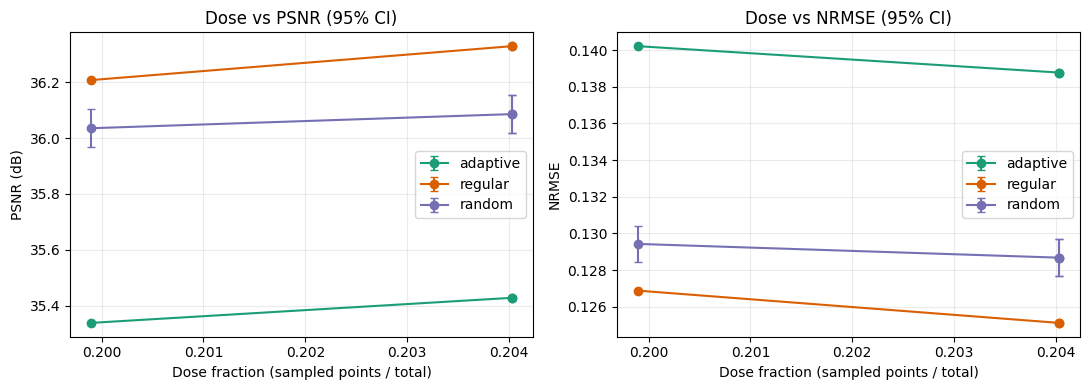

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(11, 4))
colors = {'adaptive': '#1b9e77', 'regular': '#d95f02', 'random': '#7570b3'}
for method in methods:
    x = [summary[f][method]['dose_mean'] for f in fractions]
    y_psnr = [summary[f][method]['psnr_mean'] for f in fractions]
    yerr_psnr = [
        [summary[f][method]['psnr_mean'] - summary[f][method]['psnr_ci_low'] for f in fractions],
        [summary[f][method]['psnr_ci_high'] - summary[f][method]['psnr_mean'] for f in fractions],
    ]
    ax[0].errorbar(x, y_psnr, yerr=yerr_psnr, marker='o', capsize=3, color=colors[method], label=method)
    y_nrmse = [summary[f][method]['nrmse_mean'] for f in fractions]
    yerr_nrmse = [
        [summary[f][method]['nrmse_mean'] - summary[f][method]['nrmse_ci_low'] for f in fractions],
        [summary[f][method]['nrmse_ci_high'] - summary[f][method]['nrmse_mean'] for f in fractions],
    ]
    ax[1].errorbar(x, y_nrmse, yerr=yerr_nrmse, marker='o', capsize=3, color=colors[method], label=method)
ax[0].set_title('Dose vs PSNR (95% CI)')
ax[0].set_xlabel('Dose fraction (sampled points / total)')
ax[0].set_ylabel('PSNR (dB)')
ax[0].grid(alpha=0.25)
ax[1].set_title('Dose vs NRMSE (95% CI)')
ax[1].set_xlabel('Dose fraction (sampled points / total)')
ax[1].set_ylabel('NRMSE')
ax[1].grid(alpha=0.25)
for a in ax:
    a.legend()
plt.tight_layout()
fig_path = OUT / 'dose_quality_ci.png'
plt.savefig(fig_path, dpi=200)
print('Saved:', fig_path)


In [7]:
chosen_fraction = 0.3
plan = w.suggest_adaptive_path(
    coarse_step=4,
    target_fraction=chosen_fraction,
    min_spacing=2,
    dose_lambda=0.25,
    update_widget_path=True,
    autoplay=False,
)
w.pos_row, w.pos_col = plan['path_points'][len(plan['path_points']) // 2]
pub_fig = w.save_figure(
    OUT / 'adaptive_30pct_publication.png',
    template='publication_dp_vi_fft',
    annotations={'virtual': 'Adaptive 30% path midpoint'}
)
seq_manifest = w.save_sequence(
    OUT / 'adaptive_30pct_path_sequence',
    mode='path',
    view='all',
    format='png',
    path_points=plan['path_points'],
    include_overlays=True,
    include_scalebar=True,
    filename_prefix='adaptive30',
)
report = w.save_reproducibility_report(OUT / 'adaptive_session_report.json')
with (OUT / 'benchmark_summary.json').open('w') as f:
    json.dump(summary, f, indent=2)
print('Path points:', plan['path_count'])
print('Selected fraction:', plan['selected_fraction'])
print('Saved publication figure:', pub_fig)
print('Saved sequence manifest:', seq_manifest)
print('Saved report:', report)

Path points: 395
Selected fraction: 0.2040289256198347
Saved publication figure: notebooks/show4dstem/paper_benchmark/adaptive_30pct_publication.png
Saved sequence manifest: notebooks/show4dstem/paper_benchmark/adaptive_30pct_path_sequence/save_sequence_manifest.json
Saved report: notebooks/show4dstem/paper_benchmark/adaptive_session_report.json


In [8]:
w

Show4DSTEM(shape=(44, 44, 72, 72), sampling=(0.82 Å, 0.5 mrad), pos=(15, 24))